# Importando Bibliotecas

In [ ]:
#Vincular drive no google colab
#drive.mount('/content/drive/')

In [ ]:
#Instalacao de Todos os pacotes necessários para execução do código
#pip install chart_studio numpy pandas matplotlib joblib keras tensorflow scikit-learn plotly seaborn statsmodels scipy

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(42)
seed(42)

# Pré-processamento dos dados

* Carregando os dados
* Dividindo em treino, teste e validação
* Padronizando os dados


### Carregando Dados e convertendo para Array do Numpy. Configurado apenas para séries univariadas

In [3]:
dataframe = pd.read_csv('dataframe.csv')

In [4]:
dataframe.head(5)

,TEMP
0,27.73
1,27.97
2,25.70
3,26.49
4,22.42


In [5]:
data = dataframe.values  # Converte o DataFrame para um array NumPy

### Train test split

In [6]:
# Definindo a proporção para treino, validação e teste
train_prop = 0.7
valid_prop = 0.15
test_prop = 0.15

In [7]:
# Tamanho Total de Cada Conjunto
total_data_len = len(dataframe)
train_data_len = int(np.floor(total_data_len * train_prop))
valid_data_len = int(np.floor(total_data_len * valid_prop))
test_data_len = int(np.floor(total_data_len * test_prop))
print(total_data_len)
print(train_data_len)
print(valid_data_len)
print(test_data_len)


564
394
84
84


### Criando Treino, Validacao e Teste sem Padronizacao dos dados

In [ ]:
# Criando conjuntos de treinamento
train_data = data[0:train_data_len, :]
X_train, Y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(Y_train))
print(len(train_data))

In [ ]:
# Criando o conjunto de validação
valid_data = data[train_data_len:train_data_len + valid_data_len, :]
X_valid, Y_valid = [], []

for i in range(60, len(valid_data)):
    X_valid.append(valid_data[i-60:i, 0])
    Y_valid.append(valid_data[i, 0])

X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_valid = np.array(Y_valid)

print(len(X_valid))
print(len(Y_valid))
print(len(valid_data))

In [ ]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

### Treino, Teste e Validacao com padronizacao dos dados

In [8]:
# Criando o escalador
scaler = MinMaxScaler(feature_range=(0,1))


# Salvar o scaler para uso posterior
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [9]:
# Definir o número de passos de entrada e saída
n_steps_in, n_steps_out = 10, 1

In [10]:
# Transformar de Series Temporais para Amostras e Saída
def create_supervised_data(data, n_steps_in, n_steps_out):
    X, Y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in, 0])  # Todas as colunas, exceto a última
        Y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, 0])  # Apenas a última coluna
    return np.array(X), np.array(Y)

### Divisão e Padronização dos Dados

In [11]:
# Definir proporção de treino
train_size = int(len(data) * train_prop)

# Dividir o conjunto de treino
train_data = data[:train_size]

# Padronizar o conjunto de treino
train_scaled = scaler.fit_transform(train_data)

X_train, Y_train = create_supervised_data(train_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de treino
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)


X_train shape: (384, 10)
Y_train shape: (384, 1)


In [12]:
# Definir proporção de validação
valid_size = int(len(data) * valid_prop)

# Dividir o conjunto de validação
valid_data = data[train_size:train_size + valid_size]

# Padronizar o conjunto de validação (usando parâmetros do treino)
valid_scaled = scaler.transform(valid_data)

# Criar dados supervisionados para validação
X_valid, Y_valid = create_supervised_data(valid_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de validação
print("X_valid shape:", X_valid.shape)
print("Y_valid shape:", Y_valid.shape)


X_valid shape: (74, 10)
Y_valid shape: (74, 1)


In [13]:
# O restante dos dados será usado para teste
test_data = data[train_size + valid_size:]

# Padronizar o conjunto de teste (usando parâmetros do treino)
test_scaled = scaler.transform(test_data)

# Criar dados supervisionados para teste
X_test, Y_test = create_supervised_data(test_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de teste
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_test shape: (76, 10)
Y_test shape: (76, 1)


### Conferindo Dimensão das Partições

In [14]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'Y_valid length: {len(Y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 384
Y_train length: 384
X_valid length: 74
Y_valid length: 74
X_test length: 76
Y_test length: 76


### Ajuste dos dados para os modelos LSTM e CNN

In [15]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (384, 10, 1)
Validation set shape (74, 10, 1)
Test set shape (76, 10, 1)


# Funções de Métricas Utilizadas e Plot dos Resultados

In [16]:
# # Função para calcular MAPE
# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
# # Função para calcular MSE
# def mean_squared_error(y_true, y_pred):
#     return np.mean((y_true - y_pred) ** 2)


In [18]:
# # Função para calcular RMSE
# def root_mean_squared_error(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [19]:
# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)

    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100

    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")

    return mae, mse, rmse, mape

In [20]:
# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta

    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]

        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")

        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")

        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")

        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

In [21]:
def plot_multiple_loss(history_standard, history_reg, history_drop, history_reg_drop):

    # Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
    plt.figure(figsize=(14, 10))

    # Modelo Simples
    plt.subplot(2, 2, 1)
    plt.plot(history_standard.history['loss'], label='Treinamento')
    plt.plot(history_standard.history['val_loss'], label='Validação')
    plt.title('Modelo Simples: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Regularização
    plt.subplot(2, 2, 2)
    plt.plot(history_reg.history['loss'], label='Treinamento')
    plt.plot(history_reg.history['val_loss'], label='Validação')
    plt.title('Modelo com Regularização: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Dropout
    plt.subplot(2, 2, 3)
    plt.plot(history_drop.history['loss'], label='Treinamento')
    plt.plot(history_drop.history['val_loss'], label='Validação')
    plt.title('Modelo com Dropout: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Regularização e Dropout
    plt.subplot(2, 2, 4)
    plt.plot(history_reg_drop.history['loss'], label='Treinamento')
    plt.plot(history_reg_drop.history['val_loss'], label='Validação')
    plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [22]:
def plot_predicts(y_pred, y_pred_reg, y_pred_drop, y_pred_reg_drop):

    # Gráficos de predição
    plt.figure(figsize=(14, 10))

    # Modelo Simples
    plt.subplot(2, 2, 1)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred, label='Predito (Simples)', color='red')
    plt.title('Modelo Simples')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Regularização
    plt.subplot(2, 2, 2)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_reg, label='Predito (Reg)', color='red')
    plt.title('Modelo com Regularização')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Dropout
    plt.subplot(2, 2, 3)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_drop, label='Predito (Drop)', color='red')
    plt.title('Modelo com Dropout')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Regularização e Dropout
    plt.subplot(2, 2, 4)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_reg_drop, label='Predito (Reg + Drop)', color='red')
    plt.title('Modelo com Regularização e Dropout')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    plt.tight_layout()
    plt.show()

# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

### Selecao de Hiperparametros

In [ ]:
epochs_mlp = 50
batch_mlp = 32
lr = 0.001
neu_mlp1 = 64 #Quantidade de Neurônios Utilizados na Primeira Camada
neu_mlp2 = 32 #Quantidade de Neurônios Utilizados na Segunda Camada

### Implementacao e ajuste do Modelo MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(neu_mlp1, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(neu_mlp2))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp.summary()

In [ ]:
#history_mlp = model_mlp.fit(X_train, Y_train,
#                            validation_data=(X_valid, Y_valid),
#                            epochs=epochs_mlp,
#                            verbose=2)

history_mlp = model_mlp.fit(X_train,
                            Y_train,
                            validation_data=(X_valid, Y_valid),
                            epochs=epochs_mlp,
                            batch_size=batch_mlp,
                            verbose=0)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1497 - val_loss: 0.0601
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0564 - val_loss: 0.0269
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0267 - val_loss: 0.0217
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0217 - val_loss: 0.0193
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0195 - val_loss: 0.0168
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0177 - val_loss: 0.0156
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0169 - val_loss: 0.0149
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0159 - val_loss: 0.0142
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0152 - val_loss: 0.0136
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148 - val_loss: 0.0131
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0144 - val_loss: 0.0127
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0142 - val_

### Implementacao e Ajuste do Modelo MLP com regularização

In [ ]:
model_mlp_reg = Sequential()
model_mlp_reg.add(Dense(neu_mlp1, activation='relu', input_dim=X_train.shape[1],
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(neu_mlp2, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(1))  # Saída
model_mlp_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_reg.summary()

In [30]:
#history_mlp_reg = model_mlp_reg.fit(X_train, Y_train,
#                           validation_data=(X_valid, Y_valid),
#                            epochs=epochs_mlp,
#                            verbose=2)

history_mlp_reg = model_mlp_reg.fit(X_train,
                                    Y_train,
                                    validation_data=(X_valid, Y_valid),
                                    epochs=epochs_mlp,
                                    batch_size=batch_mlp,
                                    verbose=1)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.7241 - val_loss: 0.6146
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5997 - val_loss: 0.5459
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5355 - val_loss: 0.4993
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4890 - val_loss: 0.4566
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4473 - val_loss: 0.4172
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4090 - val_loss: 0.3814
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3741 - val_loss: 0.3489
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3422 - val_loss: 0.3193
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3132 - val_loss: 0.2923
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2869 - val_loss: 0.2679
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2632 - val_loss: 0.2457
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2414 - val_l

### Implementacao e ajuste do modelo MLP com Dropout

In [ ]:
model_mlp_drop = Sequential()
model_mlp_drop.add(Dense(neu_mlp1, activation='relu', input_dim=X_train.shape[1]))
model_mlp_drop.add(Dropout(0.3))
model_mlp_drop.add(Dense(neu_mlp2, activation='relu'))
model_mlp_drop.add(Dropout(0.3))
model_mlp_drop.add(Dense(1))
model_mlp_drop.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_dropout.summary()



In [32]:
#history_mlp_drop = model_mlp_dropout.fit(X_train, Y_train,
#                            validation_data=(X_valid, Y_valid),
#                            epochs=epochs_mlp,
#                            verbose=2)

history_mlp_drop = model_mlp_drop.fit(X_train,
                                        Y_train,
                                        validation_data=(X_valid, Y_valid),
                                        epochs=epochs_mlp,
                                        batch_size=batch_mlp,
                                        verbose=1)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.9208 - val_loss: 0.2544
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1894 - val_loss: 0.0684
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1600 - val_loss: 0.0410
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0949 - val_loss: 0.0468
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0889 - val_loss: 0.0342
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0932 - val_loss: 0.0255
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0704 - val_loss: 0.0295
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0640 - val_loss: 0.0243
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0520 - val_loss: 0.0266
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0482 - val_loss: 0.0265
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0491 - val_loss: 0.0301
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0499 - val_l

### Implementando e Ajustando modelo MLP com Regularização e Dropout

In [ ]:
# Definição do modelo MLP com regularização e dropout
model_mlp_reg_drop = Sequential()
model_mlp_reg_drop.add(Dense(neu_mlp1, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))  # Taxa de dropout de 20%
model_mlp_reg_drop.add(Dense(neu_mlp2, activation='relu', kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))
model_mlp_reg_drop.add(Dense(1))  # Camada de saída
model_mlp_reg_drop.compile(optimizer=optimizers.Adam(lr), loss='mse', metrics=['mae'])

In [34]:
history_mlp_reg_drop = model_mlp_reg_drop.fit(X_train,
                                              Y_train,
                                              validation_data=(X_valid, Y_valid),
                                              epochs=epochs_mlp,
                                              batch_size=batch_mlp,
                                              verbose=1)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2399 - mae: 0.3047 - val_loss: 0.1313 - val_mae: 0.1615
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1599 - mae: 0.2164 - val_loss: 0.1092 - val_mae: 0.1271
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1250 - mae: 0.1609 - val_loss: 0.0930 - val_mae: 0.0969
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1085 - mae: 0.1422 - val_loss: 0.0959 - val_mae: 0.1261
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1041 - mae: 0.1420 - val_loss: 0.0823 - val_mae: 0.1026
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0973 - mae: 0.1454 - val_loss: 0.0773 - val_mae: 0.1019
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0909 - mae: 0.1423 - val_loss: 0.0754 - val_mae: 0.1092
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0844 - mae: 0.1306 - val_loss: 0.0687 - val_mae: 0.0978
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0790 - mae:

## Comparando os 4 modelos

In [35]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_mlp_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_mlp_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_mlp_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Modelo Padrão:
MAE: 0.0813
MSE: 0.0104
RMSE: 0.1018
MAPE: 18.4662%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Modelo com Regularização:
MAE: 0.0940
MSE: 0.0145
RMSE: 0.1206
MAPE: 19.5489%
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002C9534877E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━

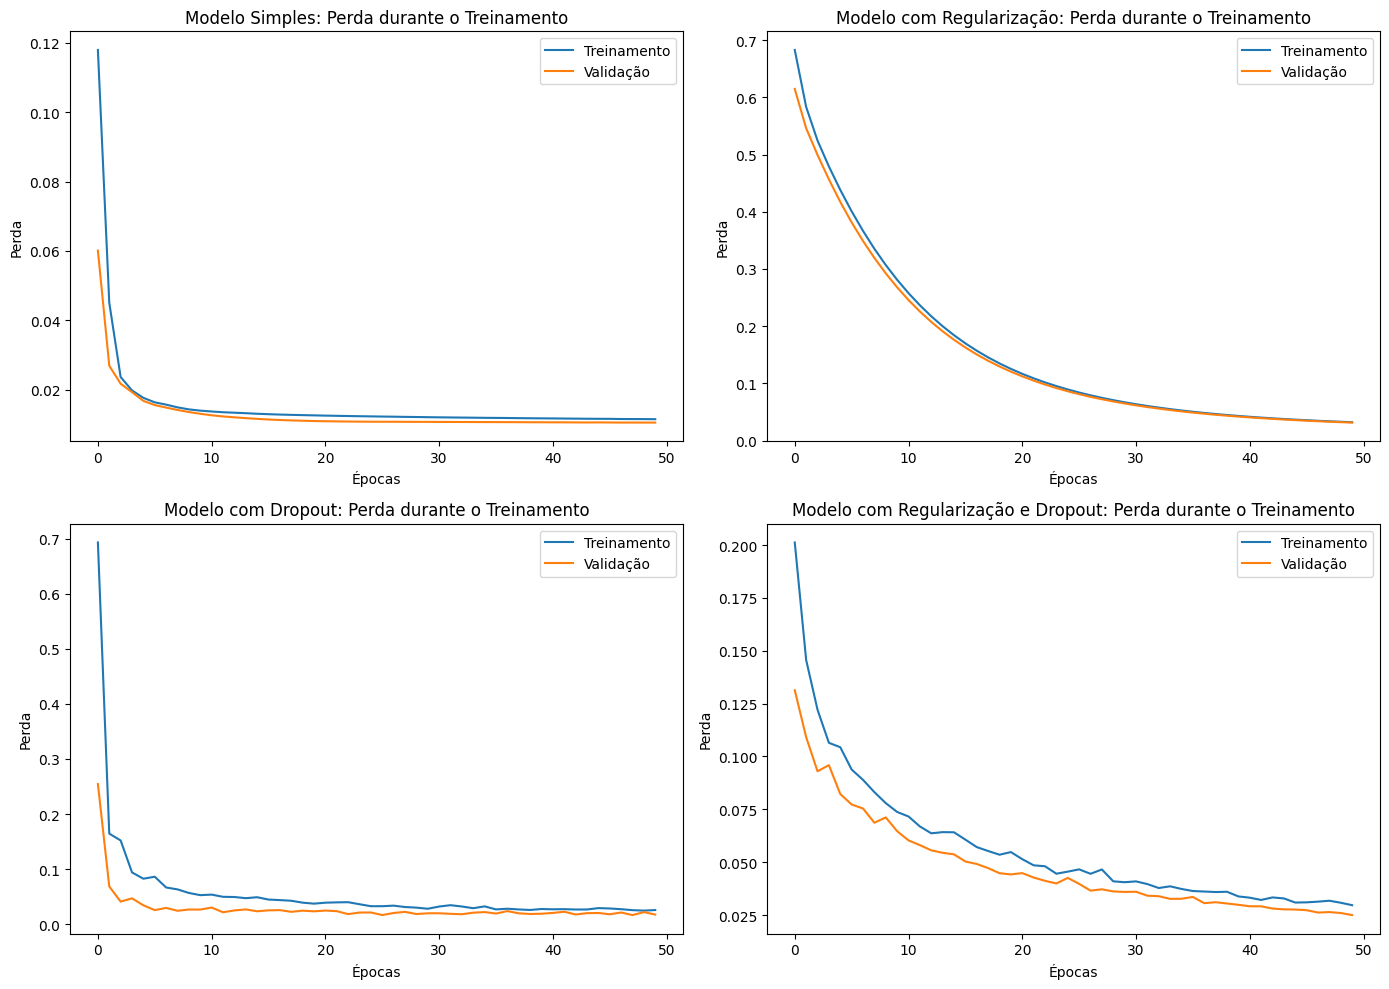

In [36]:
#Plot do Grafico de Perda
plot_multiple_loss(history_mlp, history_mlp_reg, history_mlp_drop, history_mlp_reg_drop)

In [37]:
# Gerando previsões para cada modelo
y_pred_mlp = model_mlp.predict(X_test)
y_pred_mlp_reg = model_mlp_reg.predict(X_test)
y_pred_mlp_drop = model_mlp_drop.predict(X_test)
y_pred_mlp_reg_drop = model_mlp_reg_drop.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


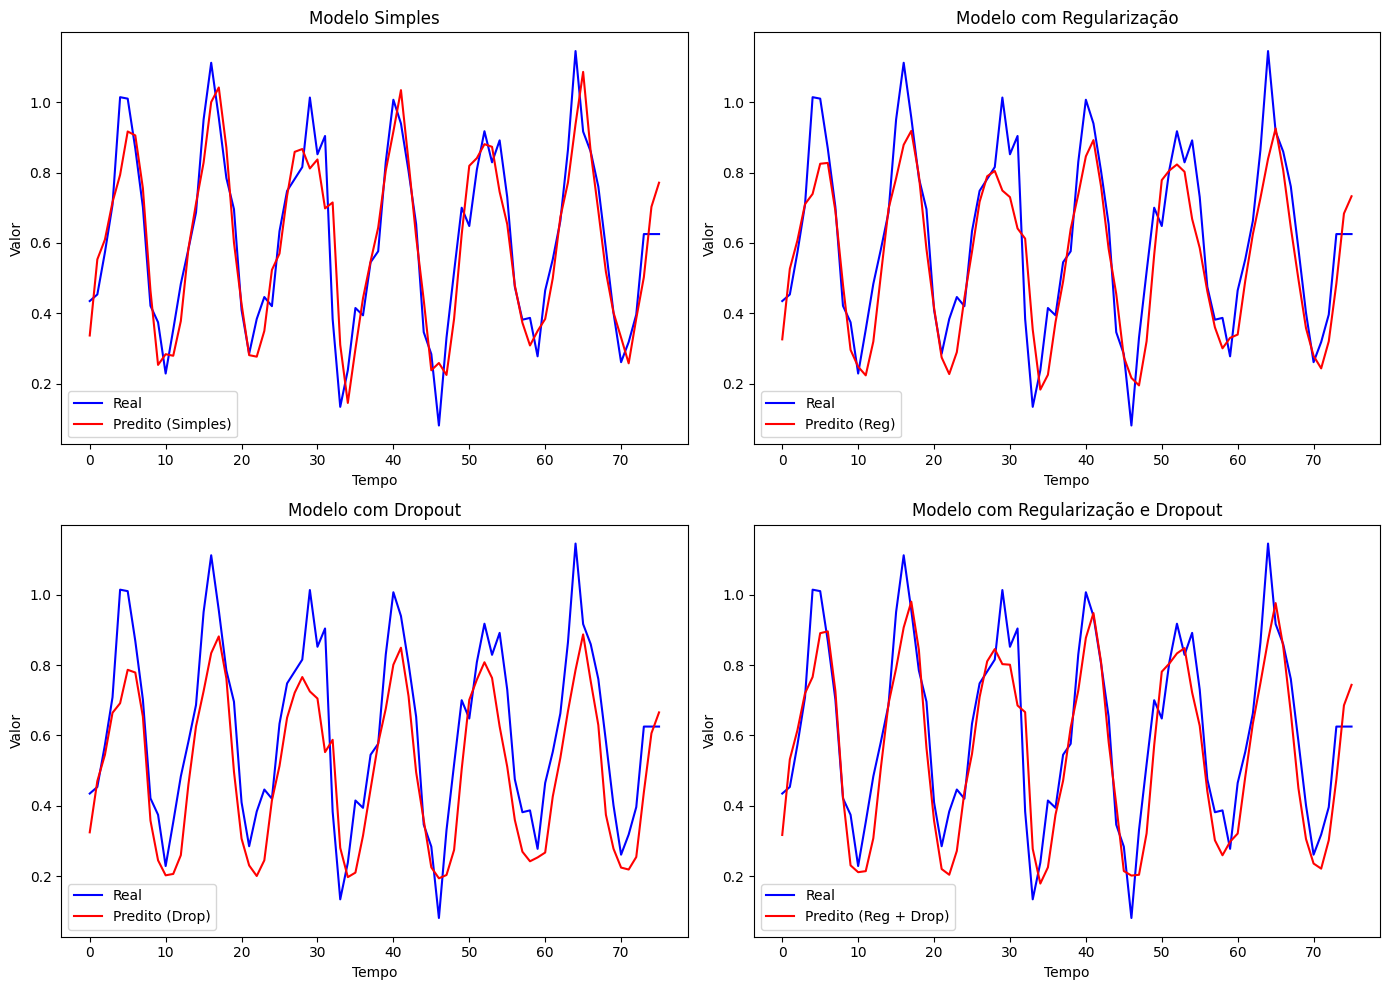

In [38]:
plot_predicts(y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop)

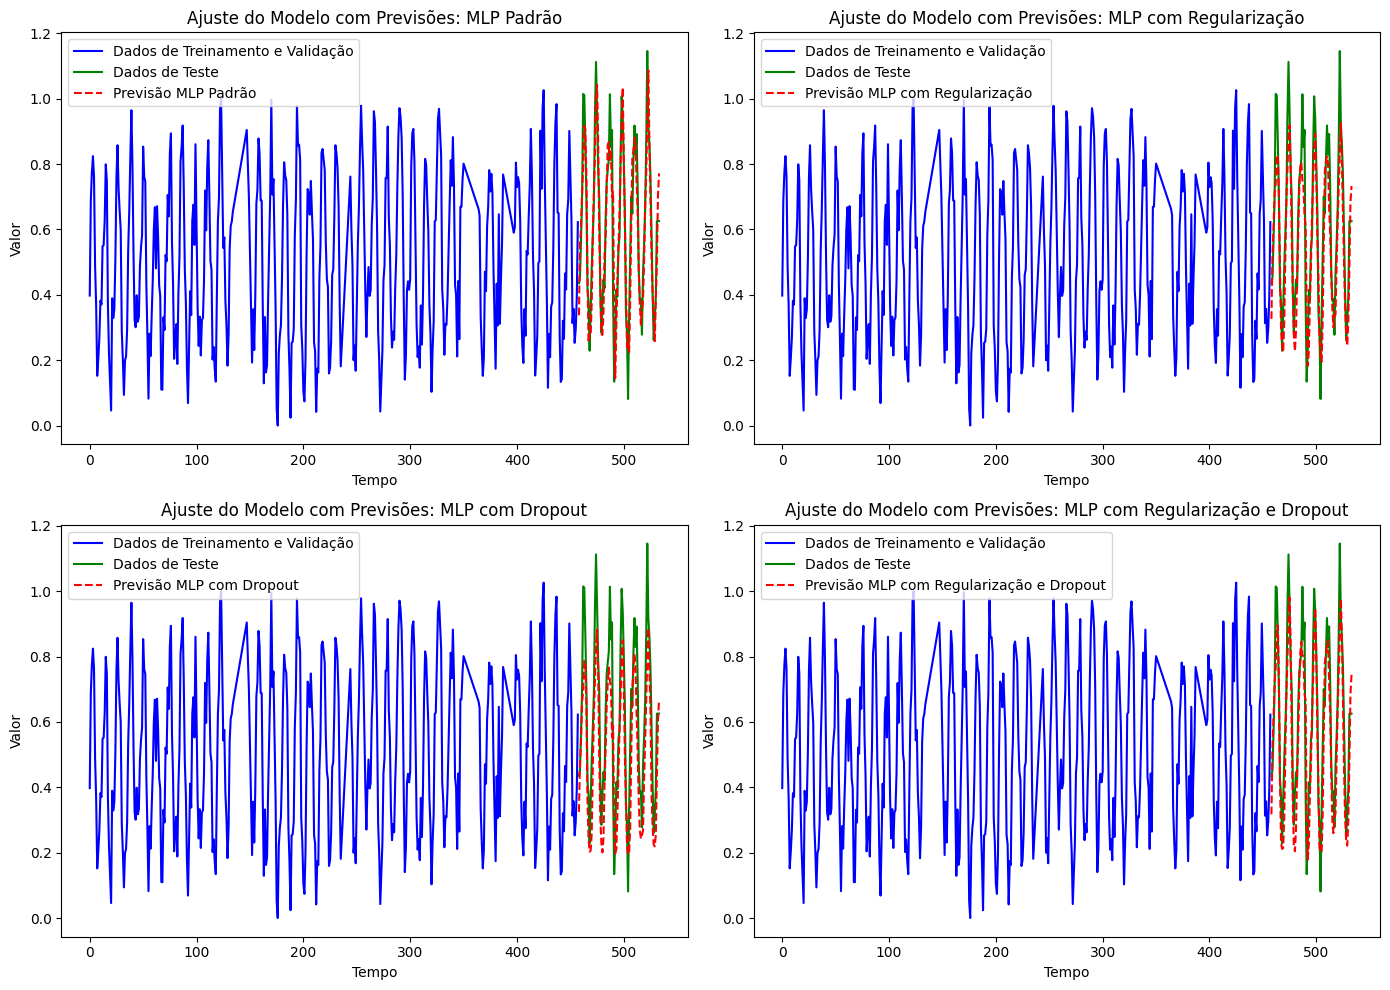

In [39]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop]
model_names = ["MLP Padrão", "MLP com Regularização", "MLP com Dropout", "MLP com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)


# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

## Seleção de Hiperparametros

In [ ]:
#Hiperparametros
epochs_cnn = 30
batch_cnn = 32
lr_cnn = 0.001
neu_cnn1 = 64 # Quantidade De Neuronios da Primeira camada
neu_cnn2 = 50 #Quantidade de Neuronios da Segunda Camada

## Implementando e Ajustando Modelo CNN

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=neu_cnn1, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(neu_cnn2, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn.summary()

In [ ]:
history_cnn = model_cnn.fit(X_train,
                            Y_train,
                            validation_data=(X_valid, Y_valid),
                            epochs=epochs_cnn,
                            batch_size=batch_cnn,
                            verbose=1)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1534 - val_loss: 0.0809
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0770 - val_loss: 0.0531
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0483 - val_loss: 0.0308
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0301 - val_loss: 0.0240
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0221 - val_loss: 0.0214
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0202 - val_loss: 0.0209
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0201 - val_loss: 0.0206
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0197 - val_loss: 0.0202
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0195 - val_loss: 0.0200
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0194 - val_loss: 0.0198
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0191 - val_loss: 0.0196
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0190 - val_l

## Implementando e Ajustando Modelo CNN com Regularização L2

In [ ]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=neu_cnn1, kernel_size=2, activation='relu',
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(neu_cnn2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_reg.summary()


In [44]:
#history_cnn_reg = model_cnn_reg.fit(X_train_series, Y_train,
#                            validation_data=(X_valid_series, Y_valid),
#                            epochs=epochs_cnn,
#                            verbose=2)

history_cnn_reg = model_cnn_reg.fit(X_train_series,
                                    Y_train,
                                    validation_data=(X_valid_series, Y_valid),
                                    epochs=epochs_cnn,
                                    batch_size=batch_cnn,
                                    verbose=1)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.0022 - val_loss: 0.7749
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7455 - val_loss: 0.6190
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5909 - val_loss: 0.4903
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4673 - val_loss: 0.3856
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3684 - val_loss: 0.3051
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2914 - val_loss: 0.2430
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2321 - val_loss: 0.1957
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1871 - val_loss: 0.1601
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1532 - val_loss: 0.1333
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1278 - val_loss: 0.1128
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1089 - val_loss: 0.0979
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0944 - v

## Implementando e Ajustando Modelo CNN com Dropout

In [ ]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=neu_cnn1, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(0.3))
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(neu_cnn2, activation='relu'))
model_cnn_drop.add(Dropout(0.3))
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_drop.summary()

In [ ]:
history_cnn_drop = model_cnn_drop.fit(X_train_series,
                                    Y_train,
                                    validation_data=(X_valid_series, Y_valid),
                                    epochs=epochs_cnn,
                                    batch_size=batch_cnn,
                                    verbose=1)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2793 - val_loss: 0.0695
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1017 - val_loss: 0.0544
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0690 - val_loss: 0.0489
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0515 - val_loss: 0.0300
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0430 - val_loss: 0.0278
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0301 - val_loss: 0.0244
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0300 - val_loss: 0.0246
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0280 - val_loss: 0.0234
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0318 - val_loss: 0.0234
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0308 - val_loss: 0.0241
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0254 - val_loss: 0.0221
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0274 - val

## Implementando e Ajustando Modelo CNN com Regularização e Dropout

In [ ]:
model_cnn_reg_drop = Sequential()
model_cnn_reg_drop.add(Conv1D(filters=neu_cnn1, kernel_size=2, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg_drop.add(MaxPooling1D(pool_size=2))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Flatten())
model_cnn_reg_drop.add(Dense(neu_cnn2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Dense(1))
model_cnn_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_reg_drop.summary()

In [ ]:
history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series,
                                            Y_train,
                                            validation_data=(X_valid_series, Y_valid),
                                            epochs=epochs_cnn,
                                            batch_size=batch_cnn,
                                            verbose=1)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.2300 - val_loss: 0.8191
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8008 - val_loss: 0.6810
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6745 - val_loss: 0.5566
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5468 - val_loss: 0.4611
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4501 - val_loss: 0.3763
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3727 - val_loss: 0.3114
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3174 - val_loss: 0.2615
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2723 - val_loss: 0.2201
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2279 - val_loss: 0.1891
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1990 - val_loss: 0.1628
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1705 - val_loss: 0.1444
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1528 - val

## Comparando os 4 Modelos CNN

In [49]:
# Previsões
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_reg = model_cnn_reg.predict(X_test)
y_pred_cnn_drop = model_cnn_drop.predict(X_test)
y_pred_cnn_reg_drop = model_cnn_reg_drop.predict(X_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [50]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Modelo Padrão:
MAE: 0.0991
MSE: 0.0167
RMSE: 0.1292
MAPE: 20.6598%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Modelo com Regularização:
MAE: 0.1369
MSE: 0.0282
RMSE: 0.1679
MAPE: 26.0815%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Modelo com Dropout:
MAE: 0.1122
MSE: 0.0216
RMSE: 0.1469
MAPE: 21.9802%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Modelo com Regularização e Dropout:
MAE: 0.1299
MSE: 0.0263
RMSE: 0.1621
MAPE: 24.9667%


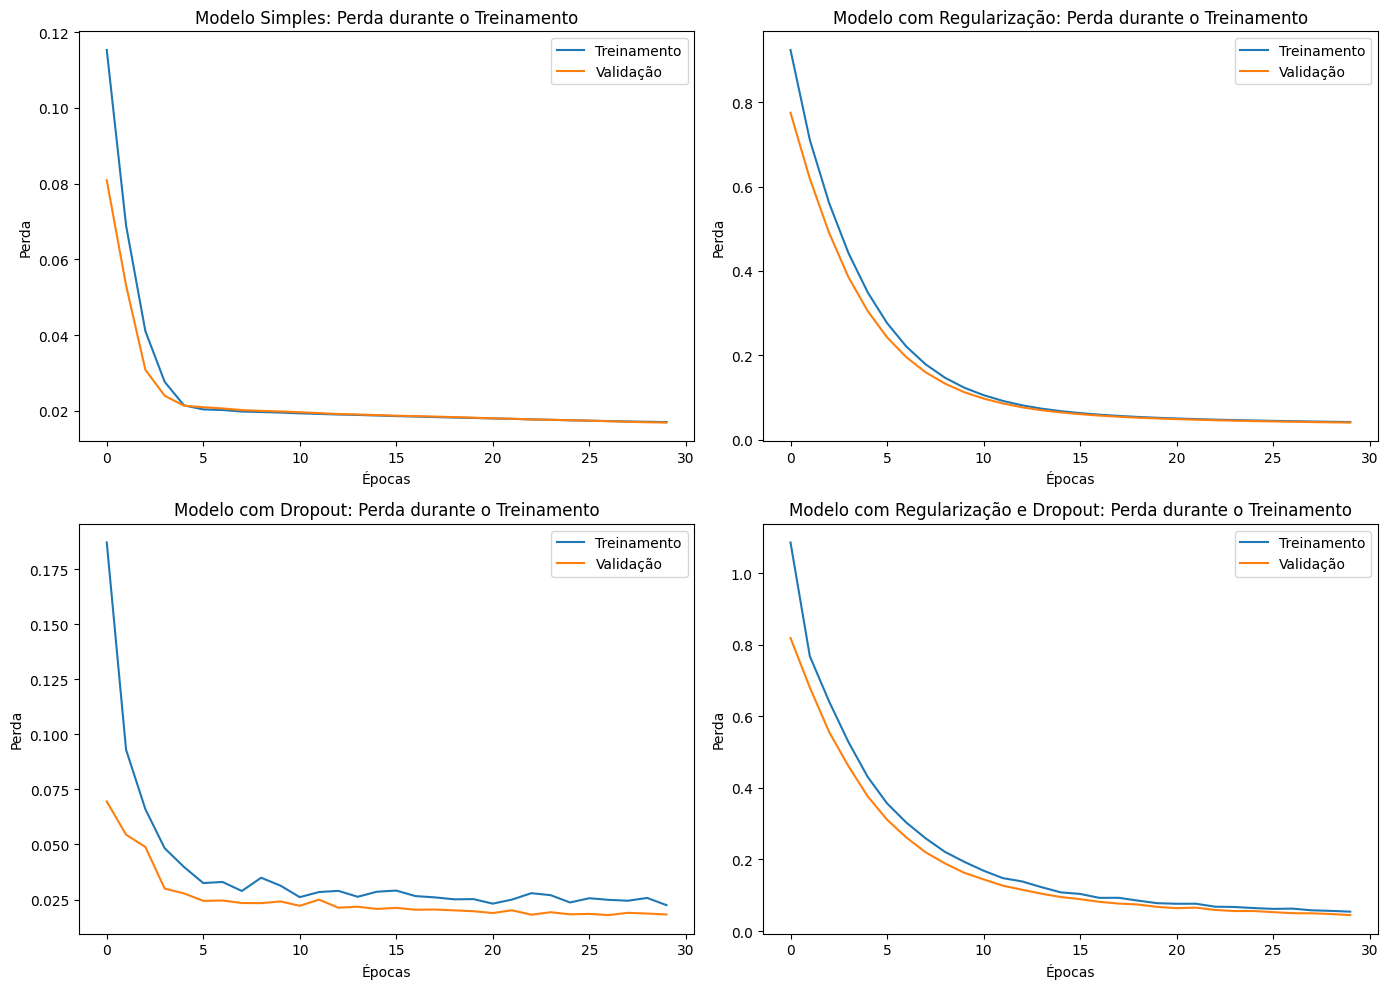

In [51]:
#Plot do Grafico de Perda
plot_multiple_loss(history_cnn, history_cnn_reg, history_cnn_drop, history_cnn_reg_drop)

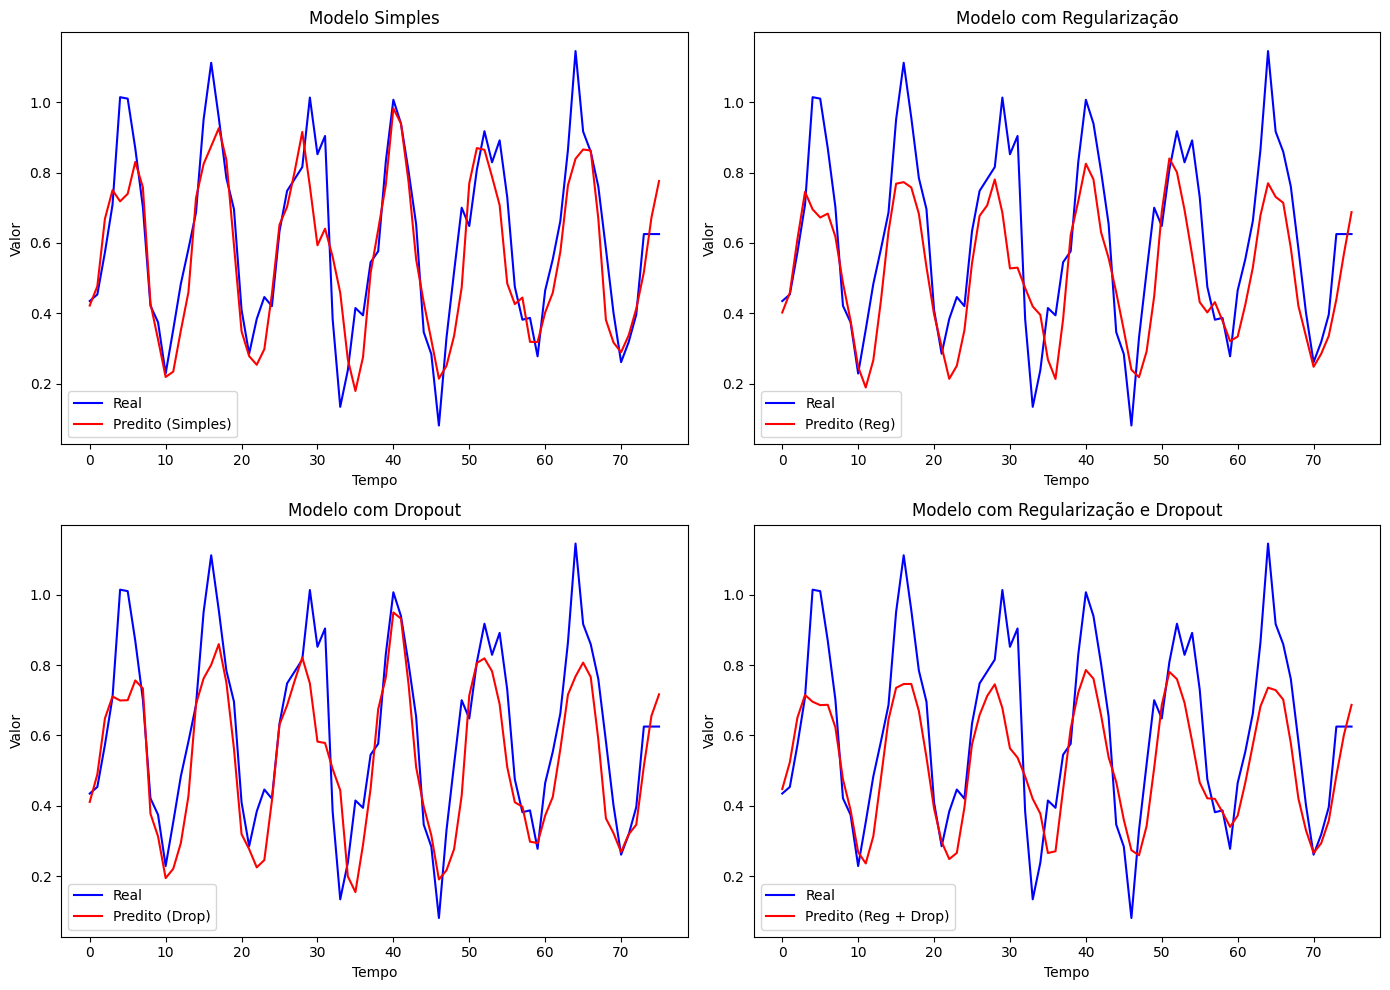

In [52]:
plot_predicts(y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop)

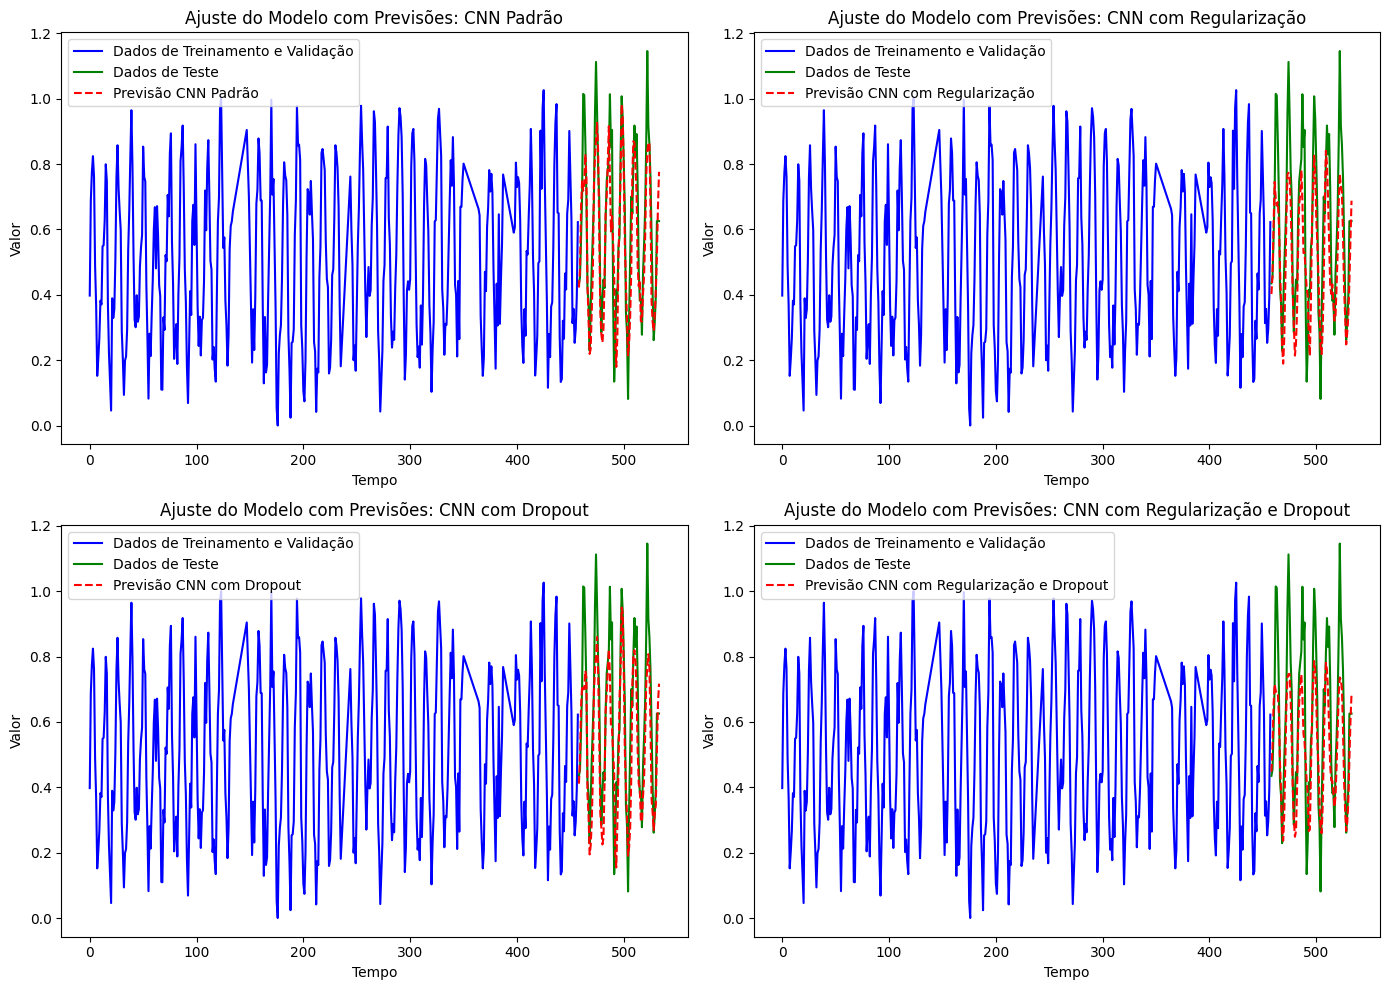

In [53]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop]
model_names = ["CNN Padrão", "CNN com Regularização", "CNN com Dropout", "CNN com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

## Pre-procesamento dos dados

In [ ]:
#Hiperparametros
epochs_lstm = 50
batch_lstm = 32
lr_lstm = 0.001
neu_lstm1 = 50 #Quantidade de Neuronios da Primeira Camada
neu_lstm2 = 50 #Quantidade de Neuronios da Segunda Camada

## Implementacao e Ajuste do Modelo LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(neu_lstm1, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm.summary()

In [56]:
history_lstm = model_lstm.fit(X_train_series,
                              Y_train,
                              validation_data=(X_valid, Y_valid),
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=1)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.3199 - val_loss: 0.2269
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1829 - val_loss: 0.0875
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0837 - val_loss: 0.0681
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0727 - val_loss: 0.0621
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0671 - val_loss: 0.0564
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0631 - val_loss: 0.0531
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0593 - val_loss: 0.0505
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0562 - val_loss: 0.0470
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0527 - val_loss: 0.0439
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0489 - val_loss: 0.0400
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0446 - val_loss: 0.0362
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.040

## Implementacao e Ajuste do Modelo LSTM com Regularizacao L2

In [ ]:
model_lstm_reg = Sequential()
model_lstm_reg.add(LSTM(neu_lstm1, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_reg.add(Dense(1))
model_lstm_reg.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_reg.summary()


In [ ]:
history_lstm_reg = model_lstm_reg.fit(X_train_series,
                              Y_train,
                              validation_data=(X_valid, Y_valid),
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=1)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.3340 - val_loss: 0.2224
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1814 - val_loss: 0.0944
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0980 - val_loss: 0.0840
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0889 - val_loss: 0.0769
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0828 - val_loss: 0.0724
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0786 - val_loss: 0.0681
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0750 - val_loss: 0.0655
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0718 - val_loss: 0.0626
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0689 - val_loss: 0.0595
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0657 - val_loss: 0.0565
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0622 - val_loss: 0.0531
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0584 - val_l

## Implementacao e Ajuste do Modelo LSTM com Dropout

In [ ]:
model_lstm_drop = Sequential()
model_lstm_drop.add(LSTM(neu_lstm1, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_drop.add(Dropout(0.3))
model_lstm_drop.add(Dense(1))
model_lstm_drop.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_dropout.summary()


In [60]:
# Treinamento do modelo com Dropout
history_lstm_drop = model_lstm_drop.fit(X_train_series,
                                              Y_train,
                                              epochs=epochs_lstm,
                                              batch_size=batch_lstm,
                                              validation_data=(X_valid, Y_valid),
                                              verbose=1)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.2760 - val_loss: 0.2081
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1808 - val_loss: 0.1034
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0975 - val_loss: 0.0650
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0836 - val_loss: 0.0625
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0751 - val_loss: 0.0556
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0699 - val_loss: 0.0504
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0618 - val_loss: 0.0489
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0584 - val_loss: 0.0430
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0533 - val_loss: 0.0386
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0482 - val_loss: 0.0348
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0495 - val_loss: 0.0358
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.04

## Implementacao e Ajuste do Modelo LSTM com Regularizacao e Dropout

In [ ]:
model_lstm_reg_drop = Sequential()
model_lstm_reg_drop.add(
    LSTM(
        neu_lstm1,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
        input_shape=(X_train_series.shape[1], X_train_series.shape[2])
    )
)
model_lstm_reg_drop.add(Dropout(0.3))
model_lstm_reg_drop.add(Dense(1))
model_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm_reg_dropout.summary()


In [ ]:
history_lstm_reg_drop = model_lstm_reg_drop.fit(X_train_series,
                            Y_train,
                            epochs=epochs_lstm,
                            batch_size=batch_lstm,
                            validation_data=(X_valid, Y_valid),
                            verbose=2)

Epoch 1/50
12/12 - 3s - 277ms/step - loss: 0.2509 - val_loss: 0.1950
Epoch 2/50
12/12 - 0s - 12ms/step - loss: 0.1395 - val_loss: 0.0864
Epoch 3/50
12/12 - 0s - 22ms/step - loss: 0.0963 - val_loss: 0.0763
Epoch 4/50
12/12 - 0s - 11ms/step - loss: 0.0879 - val_loss: 0.0739
Epoch 5/50
12/12 - 0s - 11ms/step - loss: 0.0831 - val_loss: 0.0661
Epoch 6/50
12/12 - 0s - 11ms/step - loss: 0.0760 - val_loss: 0.0605
Epoch 7/50
12/12 - 0s - 10ms/step - loss: 0.0691 - val_loss: 0.0565
Epoch 8/50
12/12 - 0s - 15ms/step - loss: 0.0655 - val_loss: 0.0521
Epoch 9/50
12/12 - 0s - 13ms/step - loss: 0.0614 - val_loss: 0.0505
Epoch 10/50
12/12 - 0s - 14ms/step - loss: 0.0591 - val_loss: 0.0432
Epoch 11/50
12/12 - 0s - 12ms/step - loss: 0.0516 - val_loss: 0.0401
Epoch 12/50
12/12 - 0s - 11ms/step - loss: 0.0491 - val_loss: 0.0403
Epoch 13/50
12/12 - 0s - 16ms/step - loss: 0.0469 - val_loss: 0.0364
Epoch 14/50
12/12 - 0s - 14ms/step - loss: 0.0398 - val_loss: 0.0359
Epoch 15/50
12/12 - 0s - 19ms/step - loss:

## Comparativo entre os modelos - Predicao e Validacao

In [63]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_lstm, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_lstm_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_lstm_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_lstm_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

Modelo Padrão:
MAE: 0.0919
MSE: 0.0131
RMSE: 0.1145
MAPE: 19.7011%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

Modelo com Regularização:
MAE: 0.1003
MSE: 0.0164
RMSE: 0.1282
MAPE: 20.6456%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

Modelo com Dropout:
MAE: 0.1002
MSE: 0.0159
RMSE: 0.1262
MAPE: 21.2836%
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step

Modelo com Regularização e Dropout:
MAE: 0.1068
MSE: 0.0182
RMSE: 0.1348
MAPE: 22.3556%


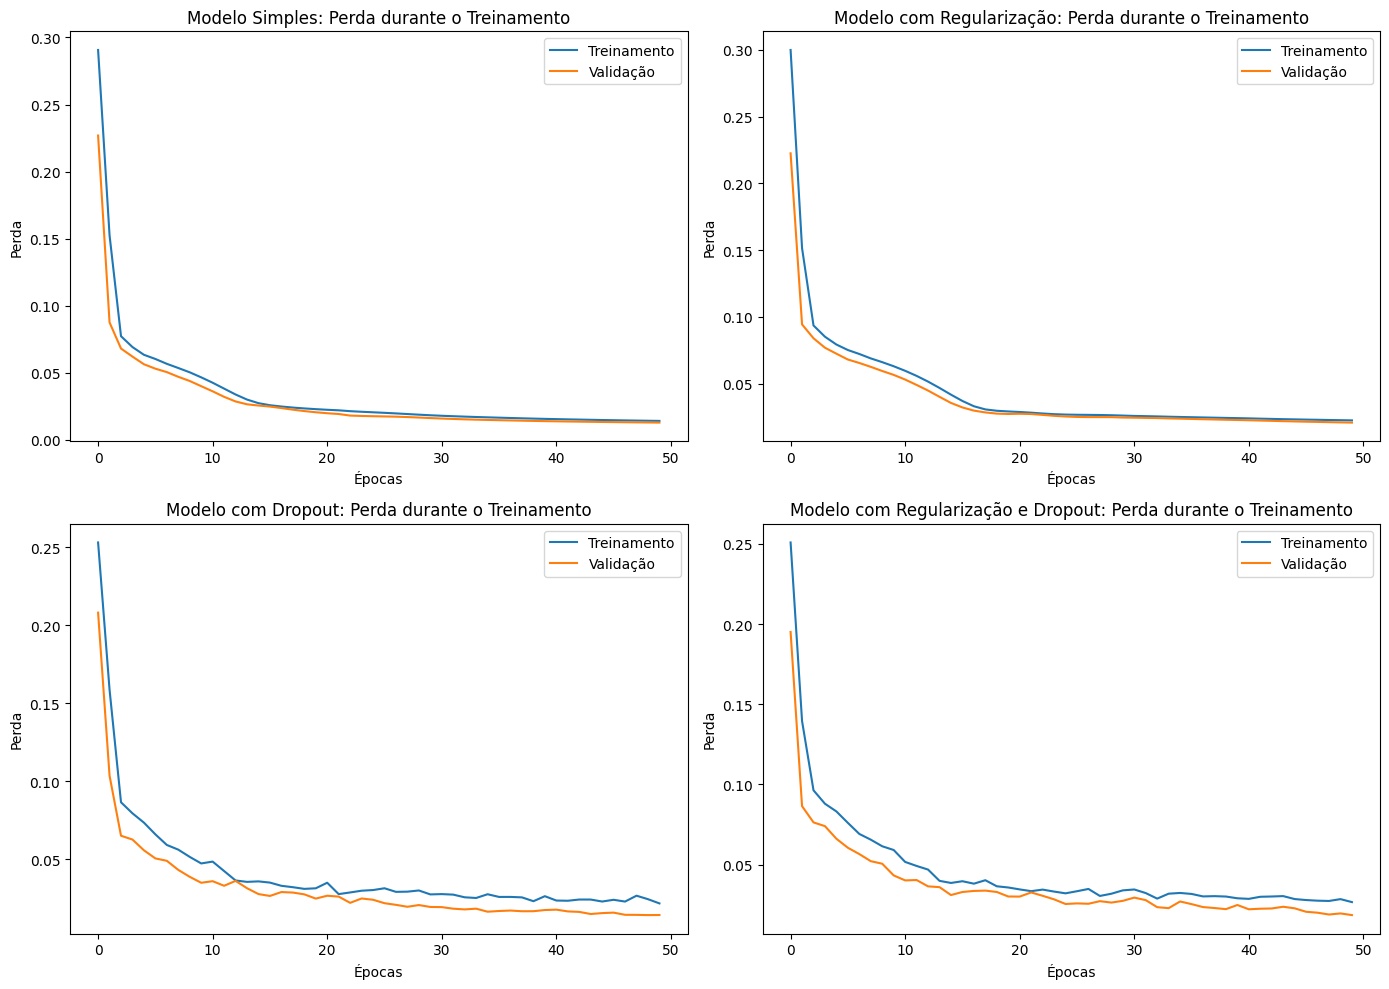

In [64]:
#Plot do Grafico de Perda
plot_multiple_loss(history_lstm, history_lstm_reg, history_lstm_drop, history_lstm_reg_drop)

In [65]:
# Obtendo as previsões dos quatro modelos
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_reg = model_lstm_reg.predict(X_test)
y_pred_lstm_drop = model_lstm_drop.predict(X_test)
y_pred_lstm_reg_drop = model_lstm_reg_drop.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


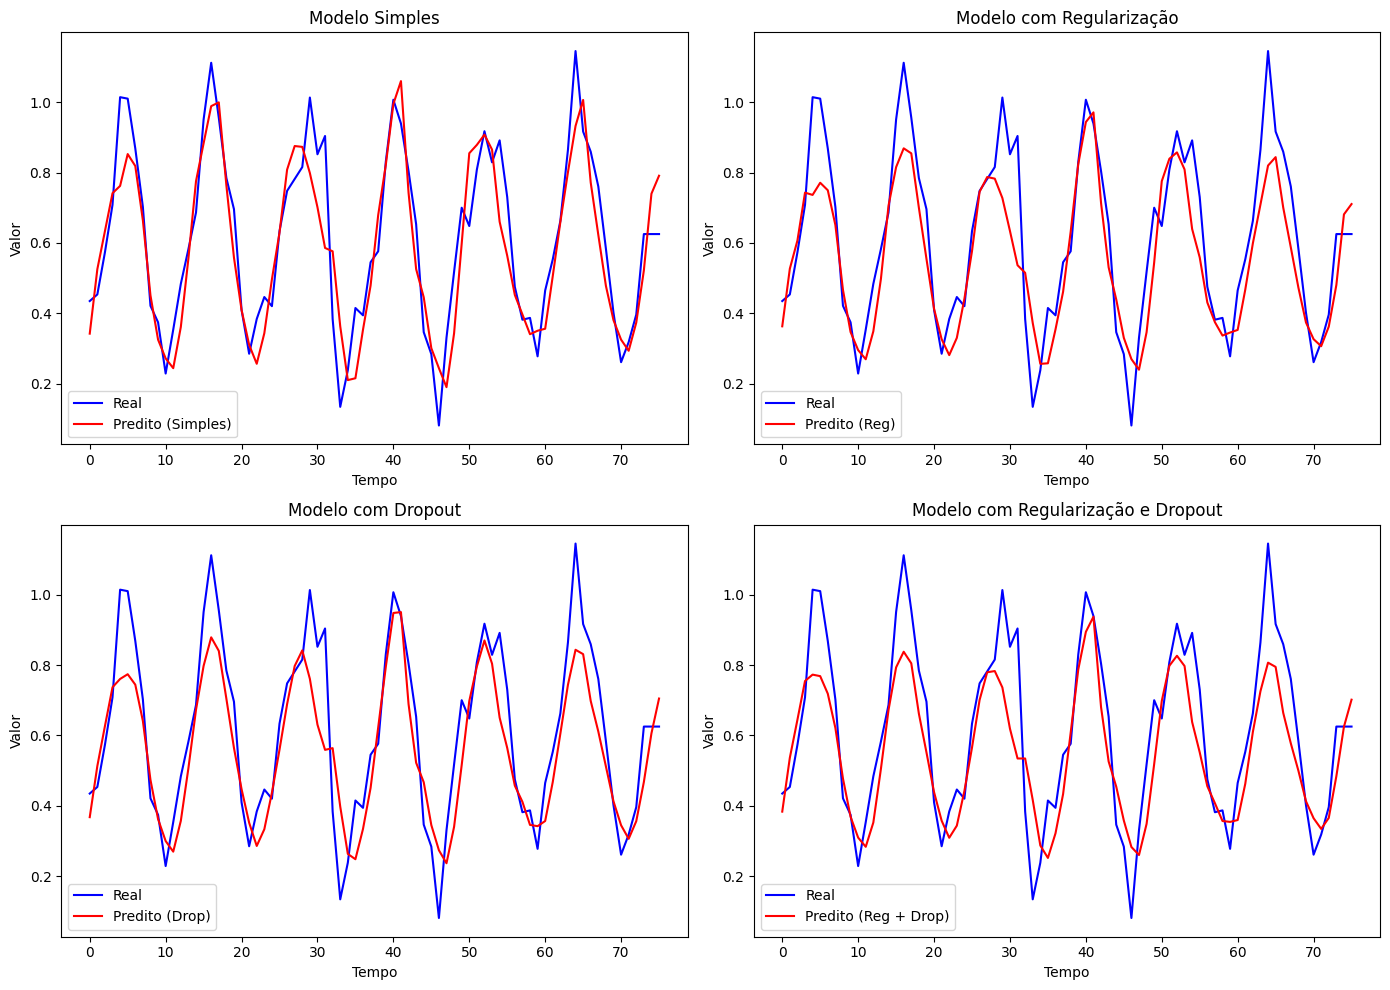

In [66]:
plot_predicts(y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop)

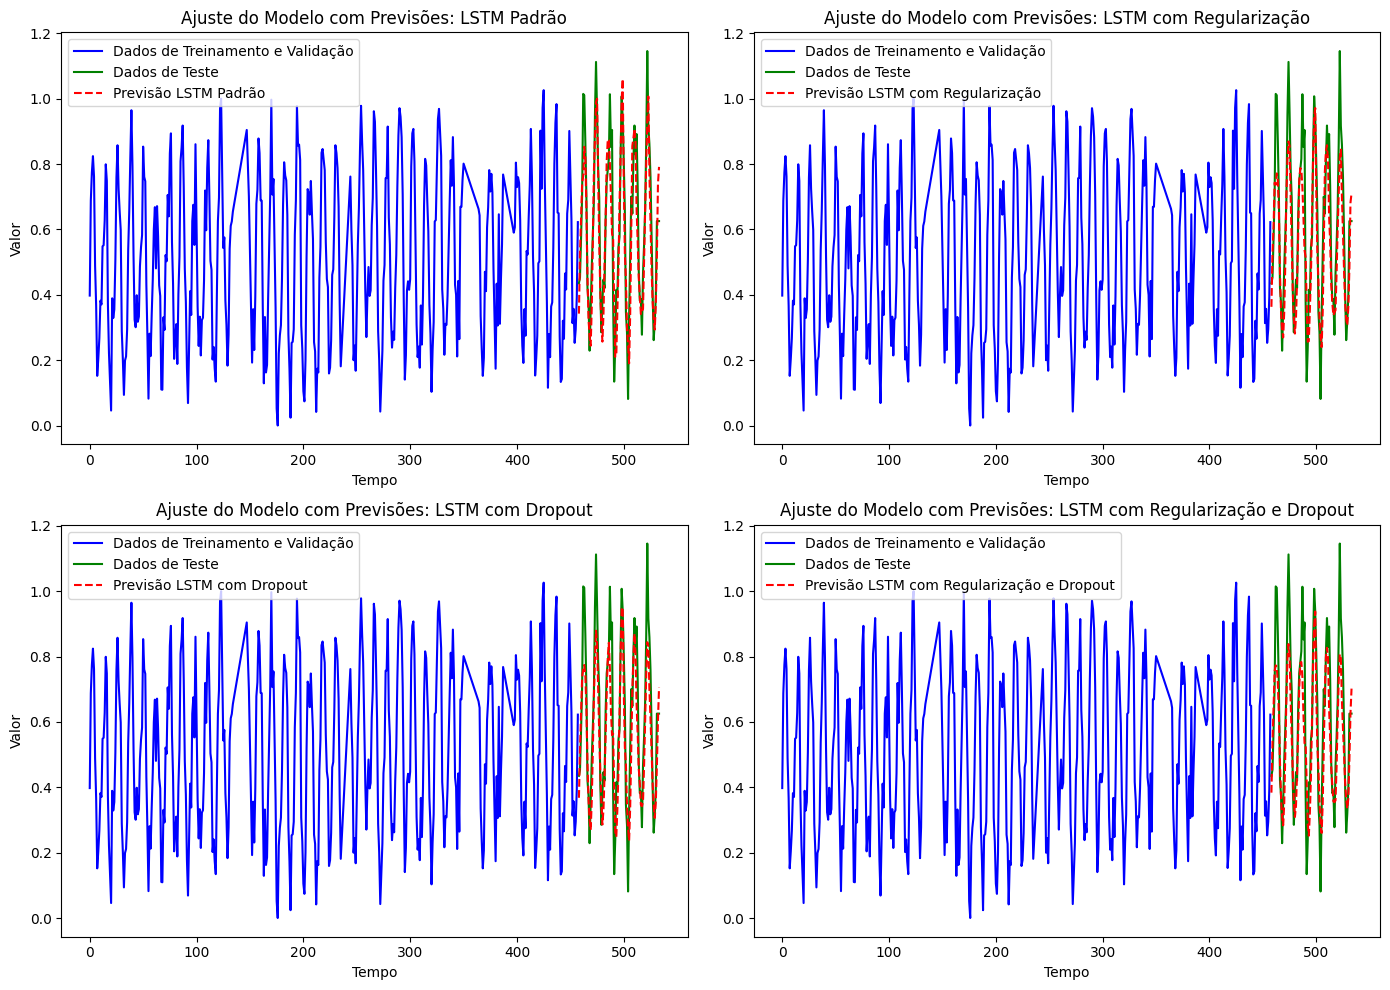

In [67]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop]
model_names = ["LSTM Padrão", "LSTM com Regularização", "LSTM com Dropout", "LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

## Pre-processamento dos dados

In [ ]:
#Hiperparametros
epochs_hibrid = 30
batch_hibrid = 32
lr_hibrid = 0.001
subsequences = 2
neu_cnn = 64 #Quantidade de Neuronios na Camada de CNN
neu_lstm = 50 #Quantidade de Neuronios na Camada de LSTM

In [69]:
timesteps = X_train.shape[1]//subsequences
X_train_series_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid.reshape((X_valid.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test.reshape((X_test.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)
print('Test set shape', X_test_series_sub.shape)

Train set shape (384, 2, 5, 1)
Validation set shape (74, 2, 5, 1)
Test set shape (76, 2, 5, 1)


## Implementacao e ajuste do modelo padrao

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=neu_cnn, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(neu_lstm, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [71]:
history_cnn_lstm = model_cnn_lstm.fit(X_train_series_sub,
                                      Y_train,
                                      validation_data=(X_valid_series_sub, Y_valid),
                                      epochs=epochs_hibrid,
                                      batch_size = batch_hibrid,
                                      verbose=1)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.2876 - val_loss: 0.1765
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1416 - val_loss: 0.0735
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0843 - val_loss: 0.0746
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0802 - val_loss: 0.0715
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0776 - val_loss: 0.0689
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0758 - val_loss: 0.0670
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0742 - val_loss: 0.0659
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0726 - val_loss: 0.0642
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0710 - val_loss: 0.0625
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0692 - val_loss: 0.0608
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0673 - val_loss: 0.0586
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0649 -

## Implementacao e Ajuste do modelo com Regularizacao

In [ ]:
model_cnn_lstm_reg = Sequential()
model_cnn_lstm_reg.add(TimeDistributed(Conv1D(filters=neu_cnn, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg.add(LSTM(neu_lstm, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg.add(Dense(1))
model_cnn_lstm_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [73]:
history_cnn_lstm_reg = model_cnn_lstm_reg.fit(X_train_series_sub,
                                              Y_train,
                                              validation_data=(X_valid_series_sub, Y_valid),
                                              epochs=epochs_hibrid,
                                              batch_size = batch_hibrid,
                                              verbose=1)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.4818 - val_loss: 0.2588
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2625 - val_loss: 0.2074
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2038 - val_loss: 0.1712
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1695 - val_loss: 0.1378
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1400 - val_loss: 0.1153
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1175 - val_loss: 0.0970
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0993 - val_loss: 0.0806
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0823 - val_loss: 0.0655
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0659 - val_loss: 0.0527
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0527 - val_loss: 0.0468
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0465 - val_loss: 0.0431
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0429

## Implementacao e Ajuste do Modelo com Dropout

In [ ]:
model_cnn_lstm_drop = Sequential()
model_cnn_lstm_drop.add(TimeDistributed(Conv1D(filters=neu_cnn, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(LSTM(neu_lstm, activation='relu'))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(Dense(1))
model_cnn_lstm_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [75]:
history_cnn_lstm_drop = model_cnn_lstm_drop.fit(X_train_series_sub,
                                                Y_train,
                                                validation_data=(X_valid_series_sub, Y_valid),
                                                epochs=epochs_hibrid,
                                                batch_size = batch_hibrid,
                                                verbose=1)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.2124 - val_loss: 0.0752
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1008 - val_loss: 0.0664
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0798 - val_loss: 0.0645
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0773 - val_loss: 0.0565
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0655 - val_loss: 0.0516
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0616 - val_loss: 0.0436
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0548 - val_loss: 0.0337
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0428 - val_loss: 0.0248
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0410 - val_loss: 0.0173
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0293 - val_loss: 0.0150
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0315 - val_loss: 0.0147
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

## Implementacao e Ajuste do Modelo com Regularizacao e Dropout

In [ ]:
model_cnn_lstm_reg_drop = Sequential()
model_cnn_lstm_reg_drop.add(TimeDistributed(Conv1D(filters=neu_cnn, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(LSTM(neu_lstm, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(Dense(1))
model_cnn_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

history_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.fit(X_train_series_sub,
                                                        Y_train,
                                                        validation_data=(X_valid_series_sub, Y_valid),
                                                        epochs=epochs_hibrid,
                                                        batch_size = batch_hibrid,
                                                        verbose=1)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.5229 - val_loss: 0.3323
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2900 - val_loss: 0.2067
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2238 - val_loss: 0.1641
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1726 - val_loss: 0.1382
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1461 - val_loss: 0.1132
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1276 - val_loss: 0.0985
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1063 - val_loss: 0.0874
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0955 - val_loss: 0.0774
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0853 - val_loss: 0.0687
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0792 - val_loss: 0.0626
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0745 - val_loss: 0.0543
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.06

## Comparativo entre os modelos

In [77]:
# Realizando previsões para cada modelo
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_series_sub)
y_pred_cnn_lstm_reg = model_cnn_lstm_reg.predict(X_test_series_sub)
y_pred_cnn_lstm_drop = model_cnn_lstm_drop.predict(X_test_series_sub)
y_pred_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.predict(X_test_series_sub)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step


In [79]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn_lstm, X_test_series_sub, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_lstm_reg, X_test_series_sub, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_lstm_drop, X_test_series_sub, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_lstm_reg_drop, X_test_series_sub, Y_test, "Modelo com Regularização e Dropout")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  

Modelo Padrão:
MAE: 0.1147
MSE: 0.0201
RMSE: 0.1418
MAPE: 23.6192%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Modelo com Regularização:
MAE: 0.0922
MSE: 0.0129
RMSE: 0.1137
MAPE: 19.5993%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Modelo com Dropout:
MAE: 0.0927
MSE: 0.0134
RMSE: 0.1160
MAPE: 19.6021%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Modelo com Regularização e Dropout:
MAE: 0.0957
MSE: 0.0152
RMSE: 0.1233
MAPE: 19.9461%


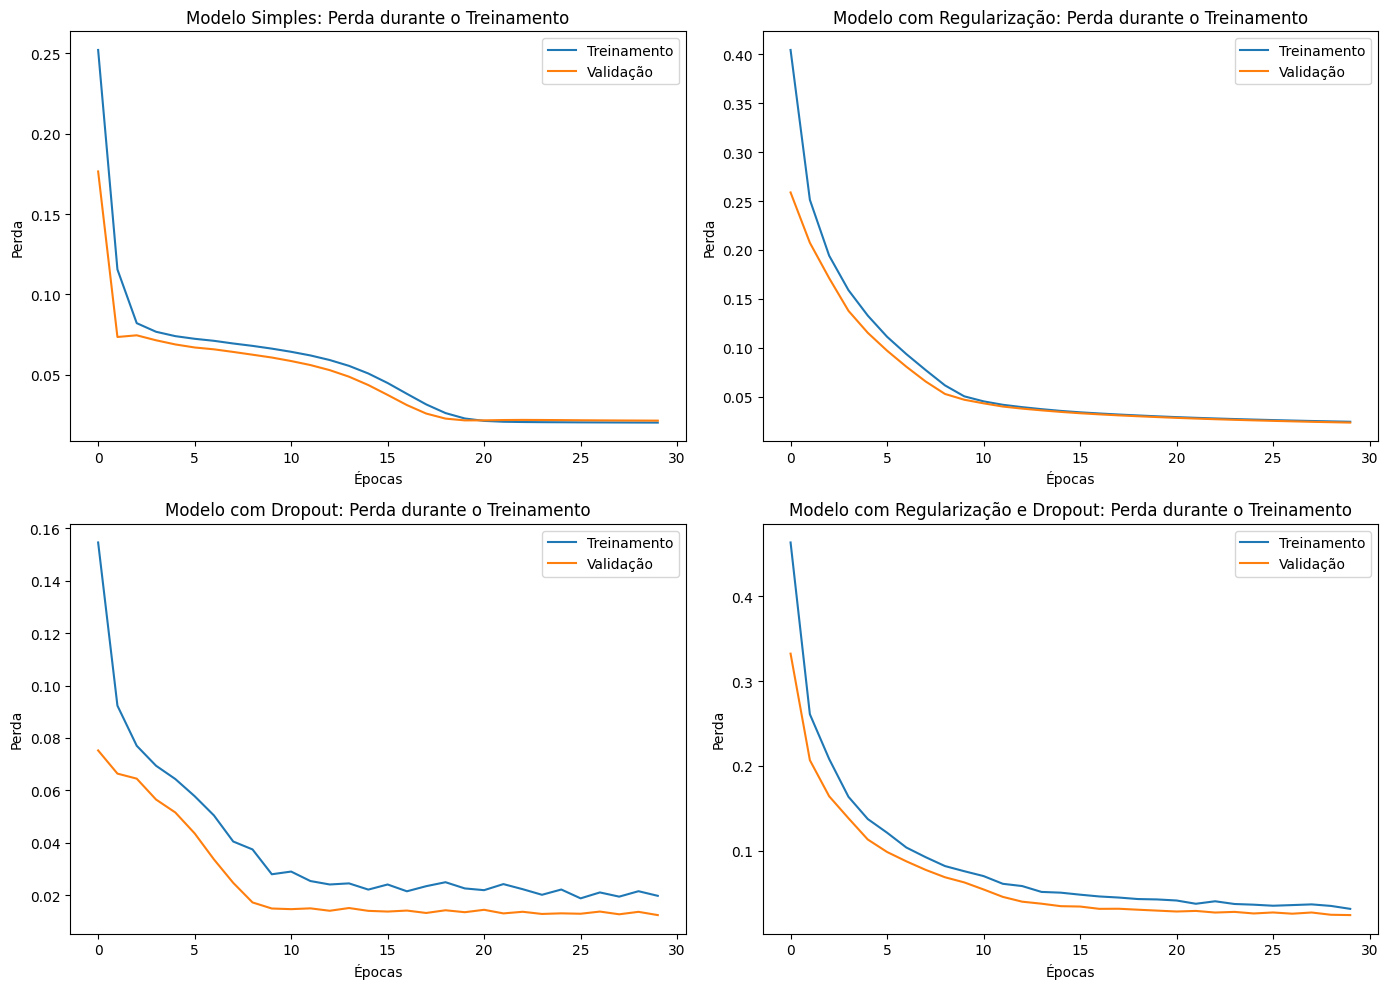

In [80]:
#Plot do Grafico de Perda
plot_multiple_loss(history_cnn_lstm, history_cnn_lstm_reg, history_cnn_lstm_drop, history_cnn_lstm_reg_drop)

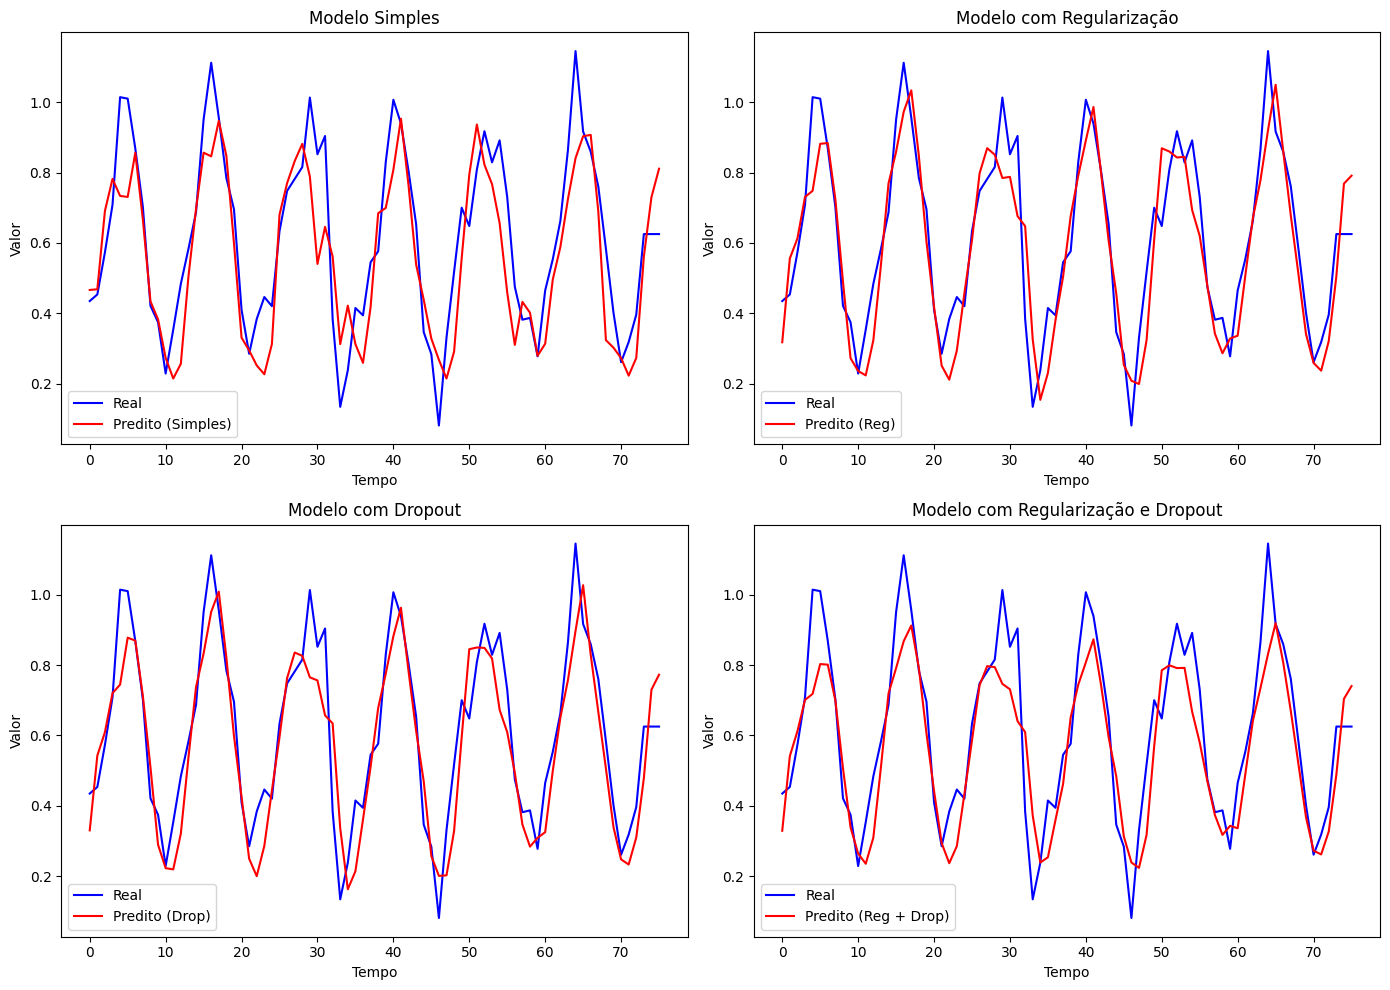

In [81]:
plot_predicts(y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop)

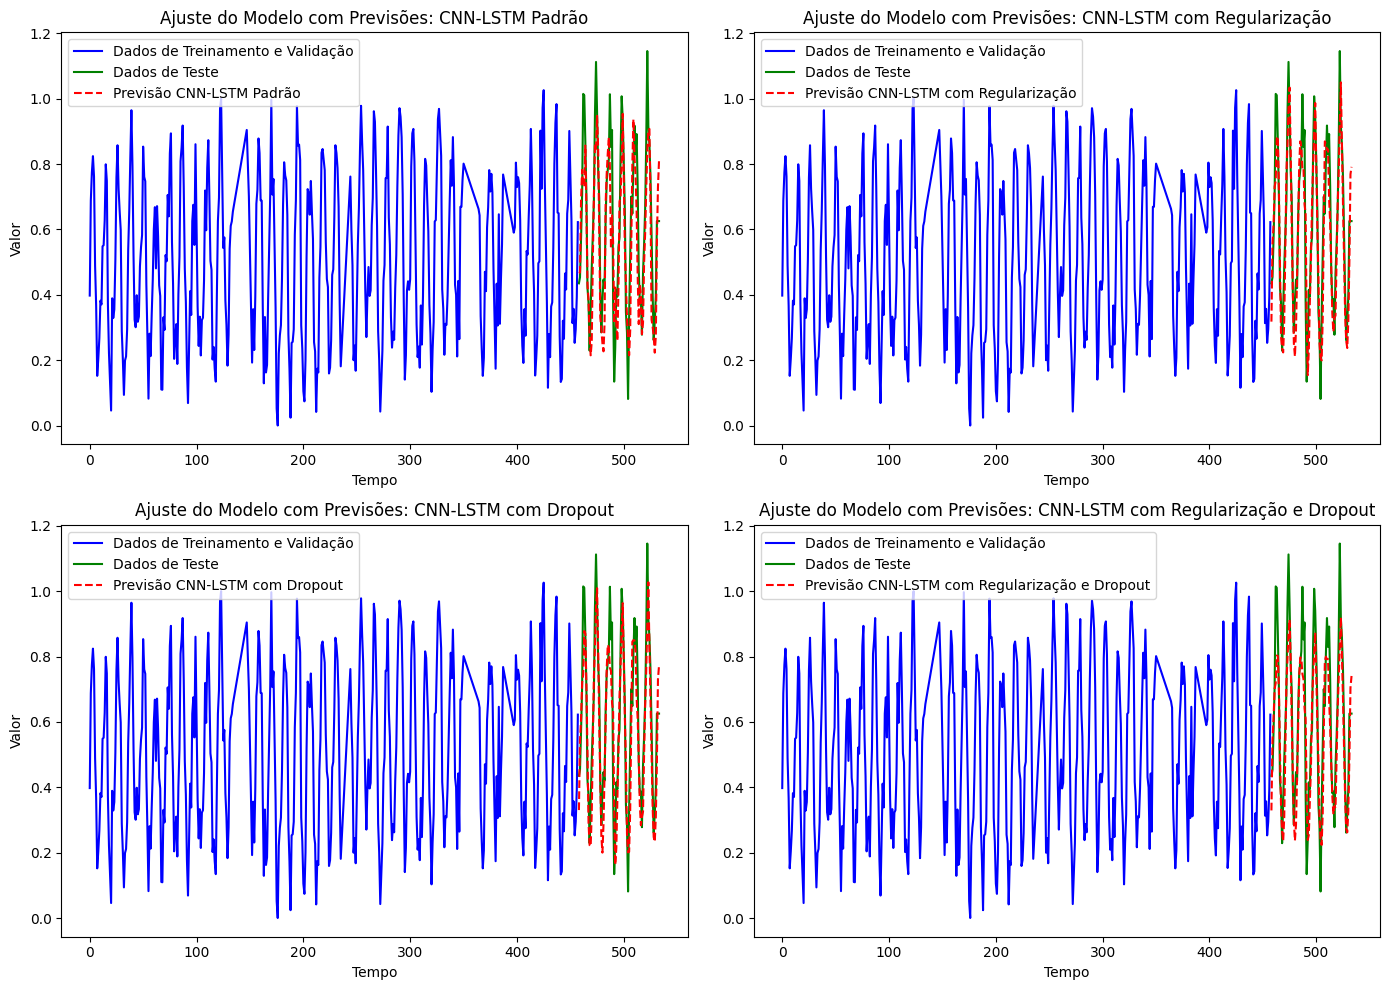

In [82]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop]
model_names = ["CNN-LSTM Padrão", "CNN-LSTM com Regularização", "CNN-LSTM com Dropout", "CNN-LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)